<a href="https://colab.research.google.com/github/jhwnoh/UST2024Fall_MaterialsInformatics/blob/main/ModelComparisons_AE_VAE_Flow_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from tqdm import tqdm

# ============================================================
#                 FIX RANDOM SEEDS (REPRODUCIBLE)
# ============================================================
import random
import numpy as np
import os

seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ============================================================
#                       DEVICE SELECTION
# ============================================================
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# ============================================================
#                           DATA
# ============================================================
X, _ = make_moons(n_samples=6000, noise=0.05)
X = torch.tensor(X, dtype=torch.float32, device=device)

mean = X.mean(0, keepdim=True)
std = X.std(0, keepdim=True)
Xn = (X - mean) / std


# ============================================================
#                       AUTOENCODER
# ============================================================
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

def train_ae():
    model = AE().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)

    for _ in tqdm(range(10000)):
        opt.zero_grad()
        loss = ((model(Xn) - Xn)**2).mean()
        loss.backward()
        opt.step()

    z = torch.randn(2000, 2, device=device)
    samples = model.decoder(z).detach() * std + mean
    return samples.cpu()


# ============================================================
#                     VARIATIONAL AUTOENCODER
# ============================================================
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(2, 64), nn.ReLU())
        self.mu = nn.Linear(64, 2)
        self.logvar = nn.Linear(64, 2)
        self.dec = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def train_vae():
    model = VAE().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)

    for _ in tqdm(range(10000)):
        opt.zero_grad()
        recon, mu, logvar = model(Xn)
        recon_loss = ((recon - Xn)**2).mean()
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
        loss = recon_loss + 0.03 * kl
        loss.backward()
        opt.step()

    z = torch.randn(2000, 2, device=device)
    samples = model.decode(z).detach() * std + mean
    return samples.cpu()


# ============================================================
#                  FAST REALNVP (CLASS-FRIENDLY)
# ============================================================
class CouplingLayer(nn.Module):
    def __init__(self, mask):
        super().__init__()
        self.mask = mask.to(device)

        self.scale = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2),
            nn.Tanh()  # keeps scale stable
        )
        self.shift = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale(x_masked) * 1.0
        t = self.shift(x_masked)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale(y_masked) * 1.0
        t = self.shift(y_masked)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        return x


class InvertibleLinear(nn.Module):
    """Cheap learnable invertible 2x2 matrix."""
    def __init__(self):
        super().__init__()
        W = torch.randn(2, 2)
        if torch.det(W) <= 0:
            W[0, 0] += 1.0
        self.W = nn.Parameter(W)

    def forward(self, x):
        y = x @ self.W
        logdet = torch.slogdet(self.W)[1]
        return y, logdet

    def inverse(self, y):
        return y @ torch.inverse(self.W)


class RealNVPFast(nn.Module):
    def __init__(self):
        super().__init__()
        self.mask1 = torch.tensor([1.0, 0.0], device=device)
        self.mask2 = torch.tensor([0.0, 1.0], device=device)

        self.c1 = CouplingLayer(self.mask1)
        self.lin = InvertibleLinear()
        self.c2 = CouplingLayer(self.mask2)

    def forward(self, x):
        y, ld1 = self.c1(x)
        y, ldLin = self.lin(y)
        y, ld2 = self.c2(y)
        return y, (ld1 + ldLin + ld2)

    def inverse(self, z):
        z = self.c2.inverse(z)
        z = self.lin.inverse(z)
        z = self.c1.inverse(z)
        return z

def train_realnvp_fast():
    model = RealNVPFast().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)

    for step in tqdm(range(10000)):
        opt.zero_grad()
        y, logdet = model(Xn)
        log_prob = -0.5 * (y**2).sum(1)
        loss = -(log_prob + logdet).mean()
        loss.backward()
        opt.step()

    z = torch.randn(2000, 2, device=device)
    samples = model.inverse(z).detach() * std + mean
    return samples.cpu()


# ============================================================
#                   IMPROVED DIFFUSION MODEL
# ============================================================
T = 150
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

class MLPDiff(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x, t):
        t_embed = t.unsqueeze(1) / T
        return self.net(torch.cat([x, t_embed], dim=1))

def train_diffusion():
    model = MLPDiff().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)

    for _ in tqdm(range(10000)):
        opt.zero_grad()
        t = torch.randint(0, T, (Xn.shape[0],), device=device)
        noise = torch.randn_like(Xn)

        ab = alphas_bar[t].unsqueeze(1)
        xt = torch.sqrt(ab) * Xn + torch.sqrt(1 - ab) * noise

        noise_pred = model(xt, t)
        loss = ((noise_pred - noise)**2).mean()
        loss.backward()
        opt.step()

    x = torch.randn(2000, 2, device=device)
    for i in reversed(range(T)):
        t = torch.full((2000,), i, device=device)
        eps = model(x, t)
        alpha = alphas[i]
        ab = alphas_bar[i]

        if i > 0:
            sigma = torch.sqrt(betas[i])
            x = (x - (1 - alpha) * eps / torch.sqrt(1 - ab)) / torch.sqrt(alpha)
            x += sigma * torch.randn_like(x)
        else:
            x = (x - (1 - alpha) * eps / torch.sqrt(1 - ab)) / torch.sqrt(alpha)

    x = x * std + mean
    return x.detach().cpu()

Using device: cuda


Training AE...


100%|██████████| 10000/10000 [00:16<00:00, 602.83it/s]


Training VAE...


100%|██████████| 10000/10000 [00:24<00:00, 400.65it/s]


Training RealNVP (fast)...


100%|██████████| 10000/10000 [00:50<00:00, 198.91it/s]


Training Diffusion...


100%|██████████| 10000/10000 [00:16<00:00, 596.76it/s]


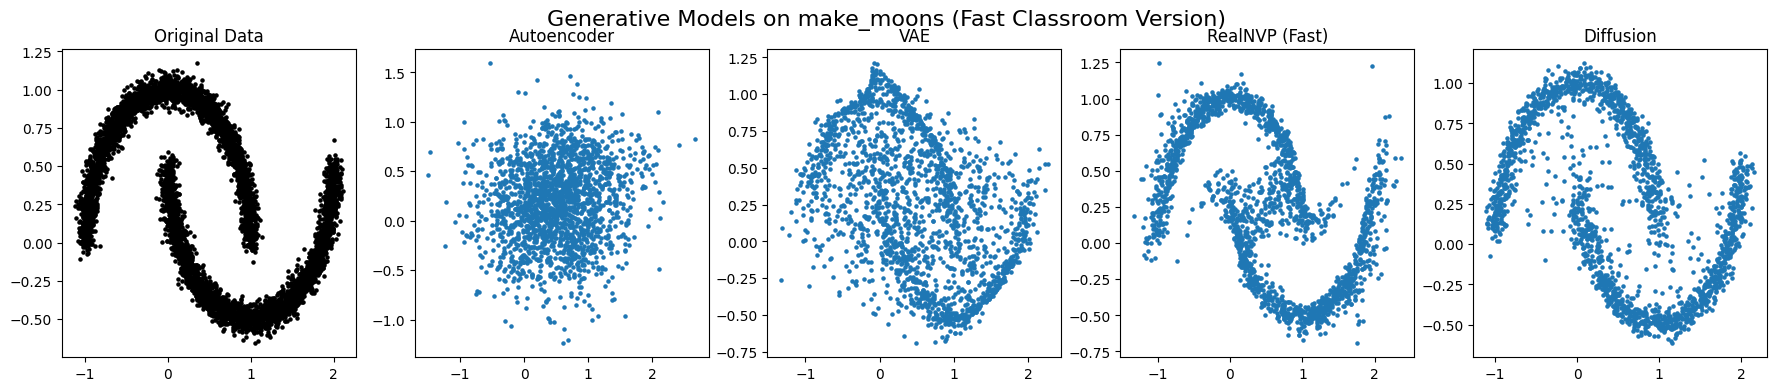

In [14]:
# ============================================================
#                    RUN ALL MODELS
# ============================================================
print("Training AE...")
s_ae = train_ae()

print("Training VAE...")
s_vae = train_vae()

print("Training RealNVP (fast)...")
s_flow = train_realnvp_fast()

print("Training Diffusion...")
s_diff = train_diffusion()


# ============================================================
#                    PLOT COMPARISON
# ============================================================
fig, axs = plt.subplots(1, 5, figsize=(22,4))

axs[0].scatter(X.cpu()[:,0], X.cpu()[:,1], s=5, c='black')
axs[0].set_title("Original Data")

axs[1].scatter(s_ae[:,0], s_ae[:,1], s=5)
axs[1].set_title("Autoencoder")

axs[2].scatter(s_vae[:,0], s_vae[:,1], s=5)
axs[2].set_title("VAE")

axs[3].scatter(s_flow[:,0], s_flow[:,1], s=5)
axs[3].set_title("RealNVP (Fast)")

axs[4].scatter(s_diff[:,0], s_diff[:,1], s=5)
axs[4].set_title("Diffusion")

plt.suptitle("Generative Models on make_moons (Fast Classroom Version)", fontsize=16)
plt.show()